<a href="https://colab.research.google.com/github/Instein125/Age-Gender-Prediction/blob/main/age_gender_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sammanstha","key":"6c0451cb5b592024a089ec15139680a0"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:18<00:00, 19.6MB/s]
100% 331M/331M [00:18<00:00, 18.6MB/s]


Extracting the zip file

In [8]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip", 'r')
zip.extractall("/content")
zip.close()

In [10]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

Counting the number of images

In [14]:
import os.path
len(os.listdir("/content/utkface_aligned_cropped/UTKFace"))

23708

In [16]:
os.listdir("/content/utkface_aligned_cropped/UTKFace")[2]
# Here 1st number denotes age, 2nd denotes gender

'7_0_0_20170110224332642.jpg.chip.jpg'

Creaing new column for age, gender and filename

In [17]:
folder_path = "/content/utkface_aligned_cropped/UTKFace"
age = []
gender = []
path = []

for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  path.append(file)

In [19]:
# Creaing a dataframe
df = pd.DataFrame({"age": age, "gender": gender, "path": path})
df.shape

(23708, 3)

In [20]:
df.head()

,age,gender,path
0,30,0,30_0_0_20170111181750341.jpg.chip.jpg
1,35,0,35_0_1_20170116222350690.jpg.chip.jpg
2,7,0,7_0_0_20170110224332642.jpg.chip.jpg
3,52,0,52_0_3_20170119205713544.jpg.chip.jpg
4,45,0,45_0_0_20170120140945913.jpg.chip.jpg


Creating a test train split set

In [21]:
train_df = df.sample(frac = 1,).iloc[:20000]
test_df = df.sample(frac = 1).iloc[20000:]

In [23]:
test_df.shape

(3708, 3)

Creating Image data generator for

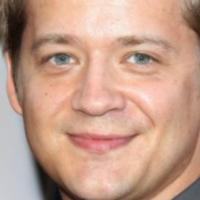

In [31]:
import keras.utils as image
image_path = folder_path + '/' +df.loc[0, 'path']
img = image.load_img(image_path )
img

In [32]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [33]:
img = image.img_to_array(img)
img.shape

(200, 200, 3)

In [35]:
train_datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        )

test_datagen = ImageDataGenerator(rescale = 1/255)

In [36]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='path',
                                                    y_col = ["age", "gender"],
                                                    target_size = (200, 200),
                                                    class_mode = 'multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=folder_path,
                                                    x_col='path',
                                                    y_col = ["age", "gender"],
                                                    target_size = (200, 200),
                                                    class_mode = 'multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


Building model using Transfer learning VGG16

In [37]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [38]:
vggnet = VGG16(include_top = False, input_shape=(200,200,3))
# include_top=False: This parameter is set to False to exclude the top (fully connected) layers of the VGG16 model.
# By setting include_top to False, we are indicating that we want to use the VGG16 model as a feature extractor
#  and not include the final classification layers.

58889256/58889256 [==============================] - 4s 0us/step


In [39]:
vggnet.trainable = False
# By setting trainable to False, we are freezing the weights of the VGG16 model,
# which means that they will remain fixed and not be updated during subsequent training or fine-tuning.

output = vggnet.layers[-1].output
# retrieves the output of the last layer in the VGG16 model for feeding it into our fully connected layer

output.shape


TensorShape([None, 6, 6, 512])

In [50]:
flatten = Flatten()(output)

dense1 = Dense(512, activation = 'relu')(flatten)
dense2 = Dense(512, activation = 'relu')(flatten)

dense3 = Dense(512, activation = 'relu')(dense1)
dense4 = Dense(512, activation = 'relu')(dense2)

output1 = Dense(1, activation = 'linear', name = 'age')(dense3)
output2 = Dense(1, activation = 'sigmoid', name = 'gender')(dense4)

In [51]:
model = Model(inputs = vggnet.input, outputs = [output1, output2])

model.compile(optimizer = 'adam',
              loss= {"age": 'mae', 'gender': 'binary_crossentropy'},
              metrics={'age': 'mae', 'gender': 'accuracy'})

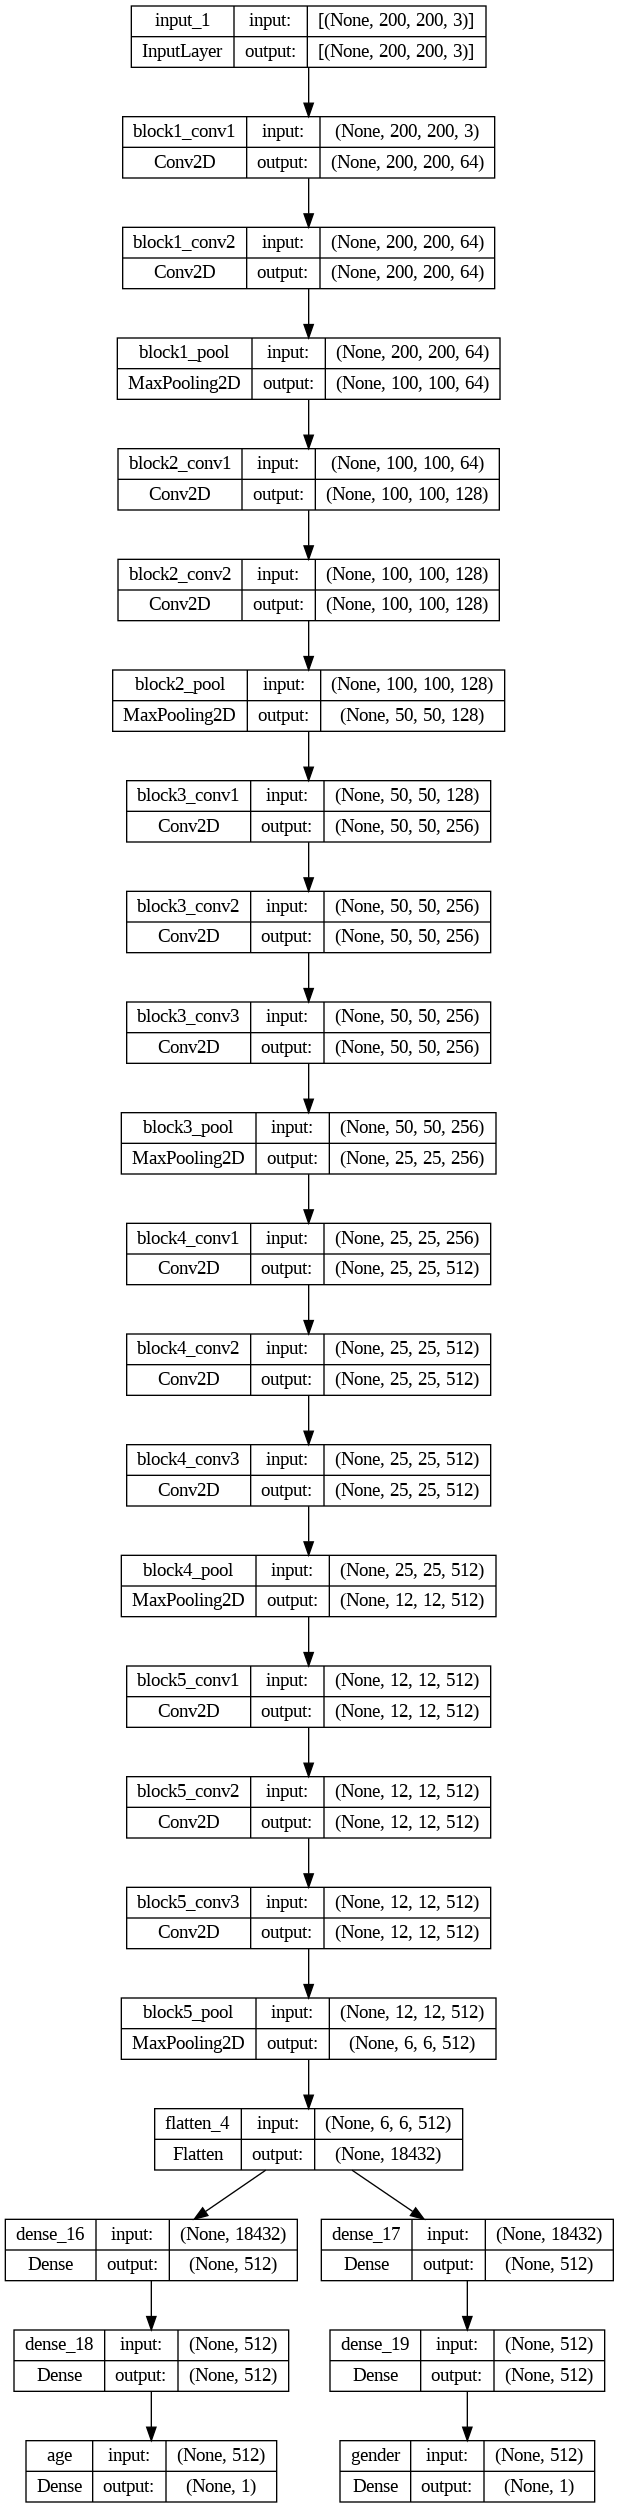

In [52]:
from keras.utils import plot_model
plot_model(model, show_shapes = True)

In [54]:
history = model.fit(train_generator, epochs = 10, batch_size = 64, validation_data = test_generator)

Epoch 1/10
625/625 [==============================] - 227s 364ms/step - loss: 9.8837 - age_loss: 9.4315 - gender_loss: 0.4522 - age_mae: 9.4315 - gender_accuracy: 0.7846 - val_loss: 8.6735 - val_age_loss: 8.2452 - val_gender_loss: 0.4283 - val_age_mae: 8.2452 - val_gender_accuracy: 0.8018
Epoch 2/10
625/625 [==============================] - 227s 363ms/step - loss: 9.4933 - age_loss: 9.0677 - gender_loss: 0.4257 - age_mae: 9.0677 - gender_accuracy: 0.7990 - val_loss: 8.9114 - val_age_loss: 8.5912 - val_gender_loss: 0.3203 - val_age_mae: 8.5912 - val_gender_accuracy: 0.8498
Epoch 3/10
625/625 [==============================] - 232s 371ms/step - loss: 9.2696 - age_loss: 8.8546 - gender_loss: 0.4150 - age_mae: 8.8546 - gender_accuracy: 0.8020 - val_loss: 8.6027 - val_age_loss: 8.2803 - val_gender_loss: 0.3224 - val_age_mae: 8.2803 - val_gender_accuracy: 0.8530
Epoch 4/10
625/625 [==============================] - 227s 363ms/step - loss: 9.1908 - age_loss: 8.7760 - gender_loss: 0.4148 - ag

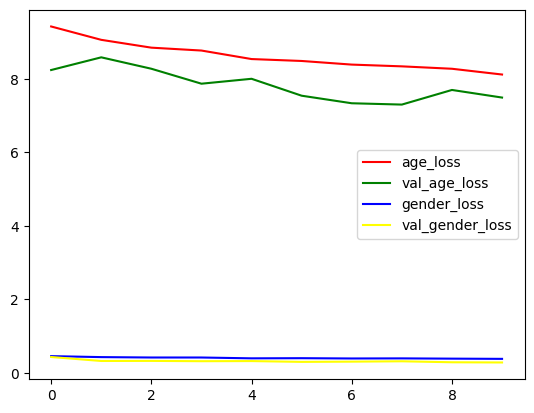

In [61]:
import matplotlib.pyplot as plt

plt.plot(history.history["age_loss"], label = "age_loss", color = 'red')
plt.plot(history.history["val_age_loss"], label = "val_age_loss", color = 'green')
plt.plot(history.history["gender_loss"], label = "gender_loss", color = 'blue')
plt.plot(history.history["val_gender_loss"], label = "val_gender_loss", color = 'yellow')
plt.legend()
plt.show()

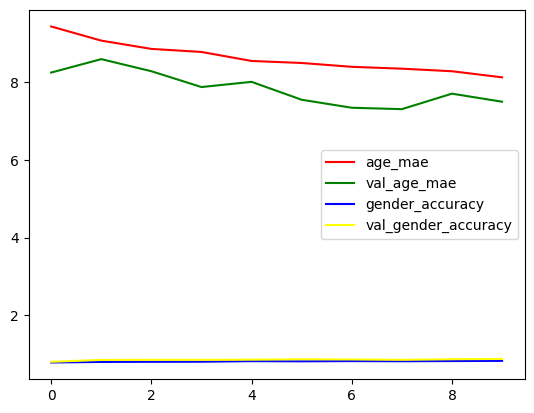

In [62]:
plt.plot(history.history["age_mae"], label = "age_mae", color = 'red')
plt.plot(history.history["val_age_mae"], label = "val_age_mae", color = 'green')
plt.plot(history.history["gender_accuracy"], label = "gender_accuracy", color = 'blue')
plt.plot(history.history["val_gender_accuracy"], label = "val_gender_accuracy", color = 'yellow')
plt.legend()
plt.show()